In [0]:
def extract_data(url, fname=None, dest=None, force_download=False):
    from urllib.request import urlopen
    from zipfile import ZipFile
    import os
    import shutil
    from pathlib import Path
    filename = url.rpartition('/')[2]
    foldername = filename.split('.')[0]
    if os.path.exists(f'{dest}/{foldername}'):
        print('Already Downloaded')
        if force_download:
            print('Removing Old Downloaded')
            shutil.rmtree(f'{dest}/{foldername}')
        else:
            return Path(f'{dest}/{foldername}')
    print('Downloading from remote server')
    response = urlopen(url)
    if dest is None: dest = '.'
    tmpzip = open(f'{dest}/{filename}', 'wb')
    tmpzip.write(response.read())
    tmpzip.close()
    if (filename.endswith("zip")):
        zf = ZipFile(f'{dest}/{filename}')
        zf.extractall(path = dest)
        zf.close()
    elif (filename.endswith("tar.gz") or filename.endswith("tgz")):
        tar = tarfile.open(filename, "r:gz")
        tar.extractall(path = dest)
        tar.close()
    elif (filename.endswith("tar")):
        tar = tarfile.open(filename, "r:")
        tar.extractall(path = dest)
        tar.close()
    os.remove(f'{dest}/{filename}')
    return Path(f'{dest}/{foldername}')

In [0]:
%matplotlib inline

In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from PIL import Image
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from skimage import io, transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
path = extract_data('http://files.fast.ai/data/dogscats.zip', dest='sample_data')
list(iter(path.iterdir()))

[PosixPath('sample_data/dogscats/models'),
 PosixPath('sample_data/dogscats/valid'),
 PosixPath('sample_data/dogscats/train'),
 PosixPath('sample_data/dogscats/sample'),
 PosixPath('sample_data/dogscats/test1')]

In [0]:
path_train = path/'train'
path_valid = path/'valid'
path_test  = path/'test1'

In [0]:
size=224
batch = 64 
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats)
    ])
}

In [0]:
class CustomImageDatset(Dataset):
    def __init__(self, root_dir, train, transform=None,  mode='train'):
        self.root_dir = root_dir
        self.train = train
        self.filenames = []
        self.targets = []
        self.transform = transform
        self.data = []
        
        self.classes = os.listdir(f'{root_dir}/{train}')
        self.c = len(self.classes)
        for i, folder in enumerate(self.classes):
            for name in os.listdir(f'{root_dir}/{train}/{folder}'):
                self.filenames.append(f'{root_dir}/{train}/{folder}/{name}')
                self.targets.append(i)
        self.len = len(self.filenames)
        

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        img_name = self.filenames[index]
        target = self.targets[index]
        image = Image.open(img_name).convert('RGB')
#         import pdb; pdb.set_trace();
        if self.transform:
            image = self.transform(image)
        image = image / 255
        data = (image, target)
        
        return data

In [0]:
train_datasets = CustomImageDatset(path, 'train', data_transforms['train'])
valid_datasets = CustomImageDatset(path, 'valid', data_transforms['valid'])

# train_datasets = datasets.ImageFolder(path_train, transform=data_transforms['train'])
# valid_datasets = datasets.ImageFolder(path_valid, transform=data_transforms['valid'])

train_dataloader = DataLoader(train_datasets, batch_size=batch, shuffle=True)
valid_dataloader = DataLoader(valid_datasets, batch_size=batch, shuffle=False)

loader = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

In [0]:
# base_model = ResNet50(weights='imagenet', include_top=False)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

In [0]:
# model = models.resnet34(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# for child in list(model.children())[:-3]:
#     for param in child.parameters():
#         param.requires_grad = False

In [0]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

In [0]:
# model = models.resnet34(pretrained=True)
# x = nn.Sequential(
#     nn.AdaptiveMaxPool2d(output_size=1),
#     nn.Linear(512, 2, bias=True),
#     nn.ReLU(),
#     nn.Linear(512, 2, bias=True)
#     )
# model.fc = x

In [0]:
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 classes - cats and dogs
model = model.cuda()

In [0]:
class LRFinder:
    def __init__(self, model, train, optimizer, criterion):
        self.model = copy.deepcopy(model)
        self.train = train
        self.criterion = criterion
        self.optimizer = optimizer
    
    def find_lr(self, init_value = 1e-8, final_value=10., beta = 0.98):
        num = len(self.train)-1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in tqdm(self.train):
            batch_num += 1
            #As before, get the loss for this mini-batch of inputs/outputs
            inputs,labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            #Compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.data
            smoothed_loss = avg_loss / (1 - beta**batch_num)
            #Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            #Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss
            #Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))
            #Do the SGD step
            loss.backward()
            self.optimizer.step()
            #Update the lr for the next step
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr
        return log_lrs, losses

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [221]:
lrf = LRFinder(model, loader['train'], optimizer, criterion)
log_lrs, losses = lrf.find_lr()

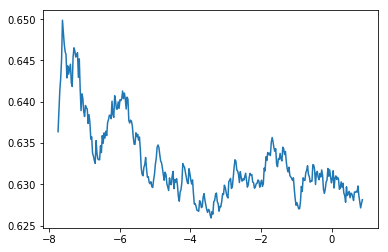

In [222]:
fig, ax = plt.subplots(1,1)
ax.plot(log_lrs[10:-5],losses[10:-5])
# ax.set_xscale('log')
# ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [0]:
class CyclicLR():
    def __init__(self, base_lr=1e-7, max_lr=1e-2, step_size=200,
                 mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.scale_mode = scale_mode
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2. ** (x-1))
            elif self.mode == 'circular':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
        self._reset()
        
    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
            
        if new_max_lr != None:
            self.max_lr = new_max_lr
            
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.basr_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    clr_triangular = CyclicLR(mode='triangular')
    optimizer.param_groups[0]['lr'] = clr_triangular.base_lr
    
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                clr_triangular.clr_iterations += 1
                clr_triangular.trn_iterations += 1
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                lr = clr_triangular.clr()
                optimizer.param_groups[0]['lr'] = lr
                clr_triangular.history.setdefault('iterations', []).append(clr_triangular.trn_iterations)
                clr_triangular.history.setdefault('lr', []).append(lr)
                clr_triangular.history.setdefault('loss', []).append(loss)

            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(loaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, clr_triangular

In [225]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=3)

Epoch 0/2
----------


train Loss: 0.1890 Acc: 0.9210


valid Loss: 0.0419 Acc: 0.9825

Epoch 1/2
----------


train Loss: 0.1432 Acc: 0.9416


valid Loss: 0.0357 Acc: 0.9870

Epoch 2/2
----------


train Loss: 0.1466 Acc: 0.9400


valid Loss: 0.0421 Acc: 0.9830

Training complete in 9m 5s
Best val Acc: 0.987000


In [0]:
clr_triangular.history

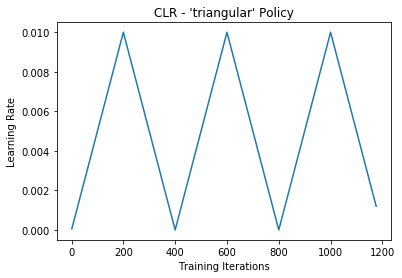

In [226]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [276]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------


train Loss: 0.1316 Acc: 0.9458


valid Loss: 0.0353 Acc: 0.9860

Training complete in 3m 1s
Best val Acc: 0.986000


In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)

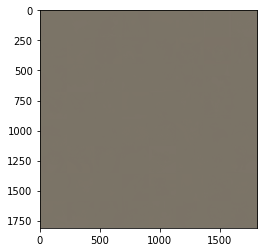

In [199]:
# change this to the trainloader or testloader 
data_iter = iter(loader['valid'])

images, labels = next(data_iter)
sample_train_images = utils.make_grid(images)
imshow(sample_train_images, title=labels)

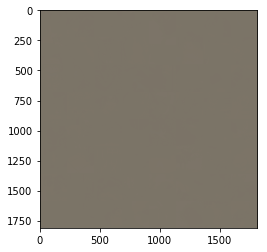

In [91]:
model.eval()

data_iter = iter(loader['train'])

images, labels = next(data_iter)
sample_train_images = utils.make_grid(images)
imshow(sample_train_images, title=labels)

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(loader['train'].dataset.classes[preds[j]]))
#                 imshow(inputs.cpu().data[j])
#                 plt.imshow(transforms.ToPILImage(mode='RGB')(inputs.cpu().data[j]))
                img = Image.open(loader['valid'].dataset.filenames[j])
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

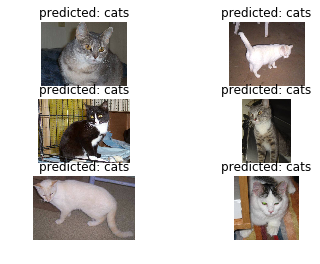

In [275]:
visualize_model(model)

plt.ioff()
plt.show()

In [0]:
import torchvision.transforms.functional as TF
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def visualizationImage(imgs):
    for index, img in enumerate(imgs):
        plt.subplot(1, 4, index + 1)
        plt.imshow(img)
        plt.axis('off')
        
        
class NormalizeInverse(transforms.Normalize):
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)
        
    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
class Hflip():
    def __call__(self,imgs):
        return [TF.hflip(img=img) for img in imgs]

class Vflip():
    def __call__(self, imgs):
        return [TF.vflip(img=img) for img in imgs]

class Rotate():
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, imgs):
        return [TF.rotate(img=img, angle=self.angle) for img in imgs]

class Grayscale():
    def __init__(self, output_channels=1):
        self.output_channels = output_channels
    def __call__(self, imgs):
        return [TF.to_grayscale(img=img, num_output_channels=self.output_channels) for img in imgs]

class Adjustbright():
    def __init__(self, bright_factor):
        self.bright_factor = bright_factor
    def __call__(self, imgs):
        return [TF.adjust_brightness(img=img, brightness_factor=self.bright_factor) for img in imgs]

class Adjustcontrast():
    def __init__(self, contrast_factor):
        self.contrast_factor = contrast_factor
    def __call__(self, imgs):
        return [TF.adjust_contrast(img=img, contrast_factor=self.contrast_factor) for img in imgs]

class Adjustsaturation():
    def __init__(self, saturation_factor):
        self.saturation_factor = saturation_factor
    def __call__(self, imgs):
        return [TF.adjust_saturation(img=img, saturation_factor=self.saturation_factor) for img in imgs]

class Adjustgamma():
    def __init__(self, gamma, gain=1):
        self.gamma = gamma
        self.gain = gain
    def __call__(self, imgs):
        return [TF.adjust_gamma(img=img, gamma=self.gamma, gain=self.gain) for img in imgs]
    

def TensorToPILs(inputs):
    imgs = [TF.to_pil_image(inputs[i]) for i in range(inputs.shape[0])]
    return imgs

def PILsToTensor(imgs):
    Norm = transforms.Normalize(mean=mean,std=std)
    tensors = [Norm(TF.to_tensor(img)) for img in imgs]
    return torch.stack(tensors)


In [0]:
import torch.nn.functional as F
tta_aug = [
    Hflip(),
    Vflip(),
    Rotate(90),
    Rotate(180)
]

class ClassPredictor():

    def __init__(self, model,device, augs = tta_aug):
        self.model = model
        self.model.eval()
        self.augs = augs
        self.device = device
        
    def predict_generator(self, loader):
        outputs = []
        true_labels = []
        for inputs, labels in tqdm(loader):
            outputs.extend(self.predict(inputs)) 
            true_labels.extend(labels)
        return outputs, true_labels

    def predict(self,inputs):
        self.preds = []
        imgs = TensorToPILs(inputs)

        for aug in self.augs:
            self.preds.append(self._predict_single(imgs,aug))
        self.preds = np.mean(np.array(self.preds),axis=0)

        return self.preds.tolist()

    def _predict_single(self, imgs, aug):
        aug_imgs = aug(imgs)
        inputs = PILsToTensor(aug_imgs)
        inputs = inputs.to(self.device)
        outputs = self.model(inputs)

        outputs = F.softmax(outputs,1)
        probs = np.mean(np.exp(outputs.detach().cpu()), axis=0, keepdims=True)
        preds = np.argmax(probs, axis=1)
#         preds_batch = outputs[:,1].tolist()

        return preds

    def __call__(self, inputs):
        return self.predict(inputs)

In [0]:
pred = ClassPredictor(model, device)

output, true_labels = pred.predict_generator(loader['valid'])

In [0]:
lrs = [1e-4, 1e-3, 1e-2]

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": model.fc.parameters(), "lr": 3e-2},
        {"params": model.layer4.parameters(), 'lr': 3e-3},
        {"params": model.layer3.parameters(), 'lr': 3e-3},
        {"params": model.layer2.parameters(), 'lr': 3e-4},
        {"params": model.layer1.parameters(), 'lr': 3e-4},
    ],
    lr=5e-5,
)

In [296]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=3)

Epoch 0/2
----------


train Loss: 0.1467 Acc: 0.9417


valid Loss: 0.0375 Acc: 0.9840

Epoch 1/2
----------


train Loss: 0.1444 Acc: 0.9439


valid Loss: 0.0365 Acc: 0.9850

Epoch 2/2
----------


train Loss: 0.1773 Acc: 0.9394


valid Loss: 0.0400 Acc: 0.9855

Training complete in 8m 51s
Best val Acc: 0.985500


In [297]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


train Loss: 0.1590 Acc: 0.9441


valid Loss: 0.0339 Acc: 0.9870

Epoch 1/9
----------


train Loss: 0.1548 Acc: 0.9442


valid Loss: 0.0354 Acc: 0.9865

Epoch 2/9
----------


train Loss: 0.1583 Acc: 0.9448


valid Loss: 0.0321 Acc: 0.9860

Epoch 3/9
----------


train Loss: 0.1706 Acc: 0.9396


valid Loss: 0.0747 Acc: 0.9760

Epoch 4/9
----------


train Loss: 0.1676 Acc: 0.9390


valid Loss: 0.0373 Acc: 0.9850

Epoch 5/9
----------


train Loss: 0.1466 Acc: 0.9450


valid Loss: 0.0361 Acc: 0.9865

Epoch 6/9
----------


train Loss: 0.1627 Acc: 0.9424


valid Loss: 0.0476 Acc: 0.9820

Epoch 7/9
----------


train Loss: 0.1834 Acc: 0.9396


valid Loss: 0.0832 Acc: 0.9765

Epoch 8/9
----------


train Loss: 0.1751 Acc: 0.9418


valid Loss: 0.0618 Acc: 0.9780

Epoch 9/9
----------


train Loss: 0.1645 Acc: 0.9443


valid Loss: 0.0401 Acc: 0.9855

Training complete in 29m 21s
Best val Acc: 0.987000
